# Fit rectangle

In [18]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy.optimize as opt
import config
from sklearn import linear_model, datasets
import random

Read the sample point cloud and visualize it.

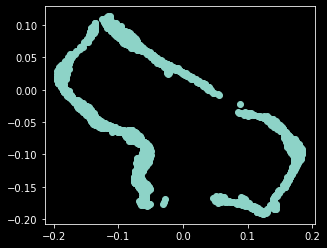

In [116]:
coordinates = np.load("coordinates5.npy")
plt.gca().set_aspect('equal')
plt.scatter(coordinates[:, 0], coordinates[:, 1])

## The model
Define the model. 

`rect` defines a signed distance field (SDF) for a rect with given parameters.

Parameters are:
- `p_x` x coordinate of a corner
- `p_y` y coordinate of a corner
- `w` width of the rectangle
- `h` height of the rectangle
- `a` angle of rotation

In [111]:
def rect(params, x, y):
	p_x, p_y, w, h, a = params
	f1 = -np.sin(a) * (x - p_x) - np.cos(a) * (y - p_y)
	f2 = np.sin(a) * (x - p_x) + np.cos(a) * (y - p_y) - h
	f3 = -np.cos(a) * (x - p_x) + np.sin(a) * (y - p_y)
	f4 = np.cos(a) * (x - p_x) - np.sin(a) * (y - p_y) - w
	d = np.max(np.array([f1, f2, f3, f4]), axis=0)
	return d

def get_error_function(x, y):
	return lambda params: np.sum(rect(params, x, y)**2)/len(x)

Helper functions

In [41]:
def get_min_area_rect_params(coordinates):
	rect = cv2.minAreaRect(coordinates)
	box = cv2.boxPoints(rect)
	a = np.arctan2(box[3, 0] - box[0, 0], box[3, 1] - box[0, 1])
	h = np.linalg.norm(box[3] - box[0])
	w = np.linalg.norm(box[1] - box[0])
	return box[0,0], box[0,1], w, h, a

def draw_rect_params(params, color="r"):
	p_x, p_y, w, h, a = params

	box = np.array([
		[p_x, p_y],
		[p_x + h*np.sin(a), p_y + h*np.cos(a)],
		[p_x + h*np.sin(a) + w*np.cos(a), p_y + h*np.cos(a) - w*np.sin(a)],
		[p_x + w*np.cos(a), p_y - w*np.sin(a)],
	])

	plt.plot([box[0, 0], box[1, 0]], [box[0, 1], box[1, 1]], color=color)
	plt.plot([box[1, 0], box[2, 0]], [box[1, 1], box[2, 1]], color=color)
	plt.plot([box[2, 0], box[3, 0]], [box[2, 1], box[3, 1]], color=color)
	plt.plot([box[3, 0], box[0, 0]], [box[3, 1], box[0, 1]], color=color)

## RANSAC

Width: 37.72 cm, Height: 12.76 cm


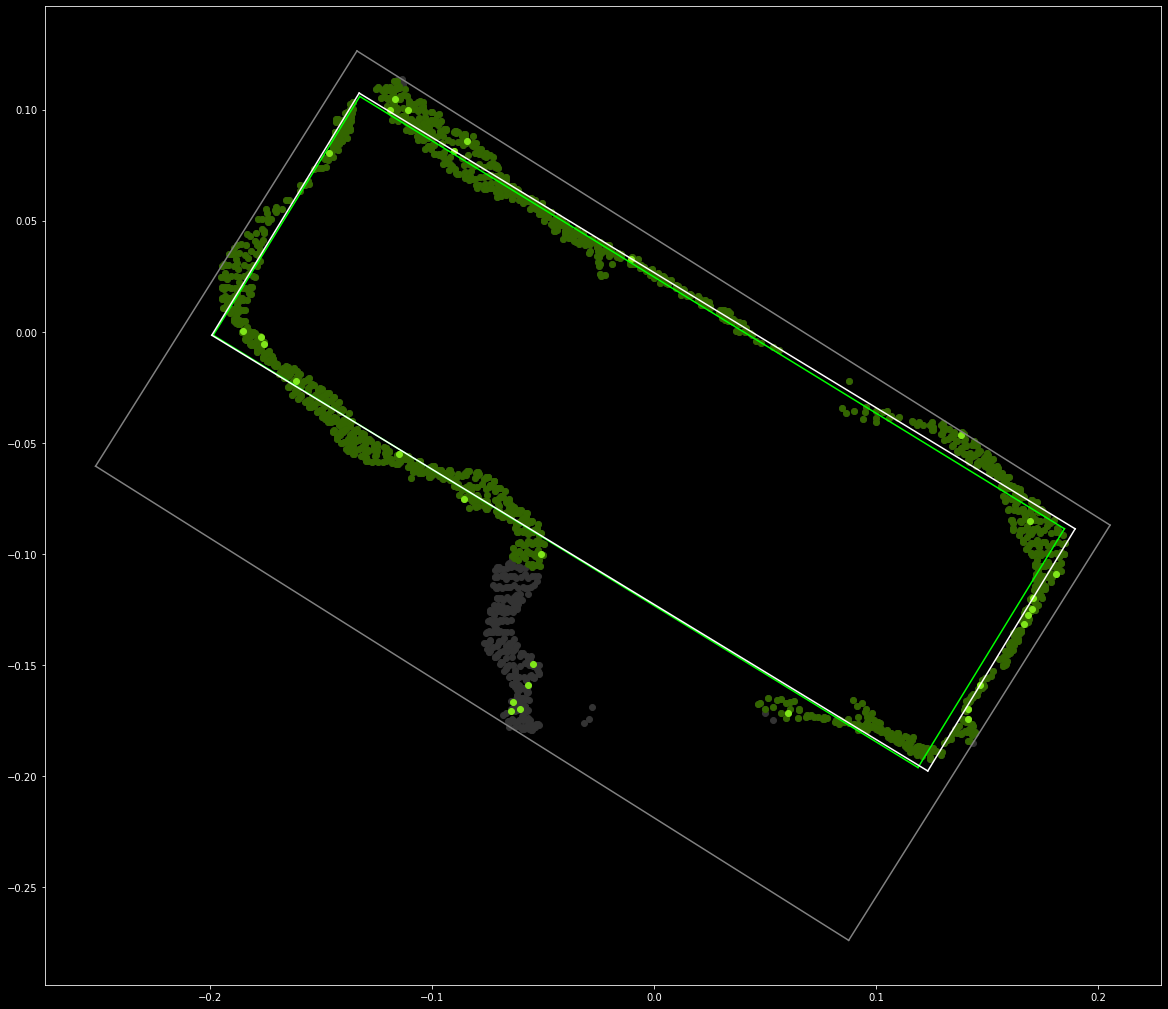

In [132]:
# RANSAC parameters
n_iterations = 50
n_samples = 30
threshold = 0.015 # m

min_area_rect_params = get_min_area_rect_params(coordinates)

best_res = min_area_rect_params
best_inliers = np.zeros(len(coordinates), dtype=bool) 
for i in range(n_iterations):
	id_sample = random.sample(range(0, len(coordinates)), n_samples)
	error_function = get_error_function(coordinates[id_sample, 0], coordinates[id_sample, 1])
	res = opt.minimize(error_function, min_area_rect_params, method="Nelder-Mead")
	distance = np.abs(rect(res.x, coordinates[:, 0], coordinates[:, 1]))
	inliers = distance < threshold
	if np.sum(inliers) > np.sum(best_inliers):
		best_res = res.x
		best_inliers = inliers

# fit the the model on the inliers
res = opt.minimize(get_error_function(coordinates[best_inliers, 0], coordinates[best_inliers, 1]), best_res, method="Nelder-Mead")
final_res = res.x

# display the results
plt.figure(figsize=(20, 20))
plt.gca().set_aspect('equal')
plt.scatter(coordinates[:, 0], coordinates[:, 1], color=(0.2, 0.2, 0.2))
plt.scatter(coordinates[best_inliers, 0], coordinates[best_inliers, 1], color=(0.2, 0.4, 0))
plt.scatter(coordinates[id_sample, 0], coordinates[id_sample, 1], color=(0.5, 0.9, 0.1))
draw_rect_params(min_area_rect_params, color=(0.5, 0.5, 0.5))
draw_rect_params(best_res, color=(0, 1, 0))
draw_rect_params(final_res, color=(1, 1, 1))

print(f"Width: {final_res[2]*100:.2f} cm, Height: {final_res[3]*100:.2f} cm")

## Signed distance field visualization

Positive region is colored green and negative region is colored red.

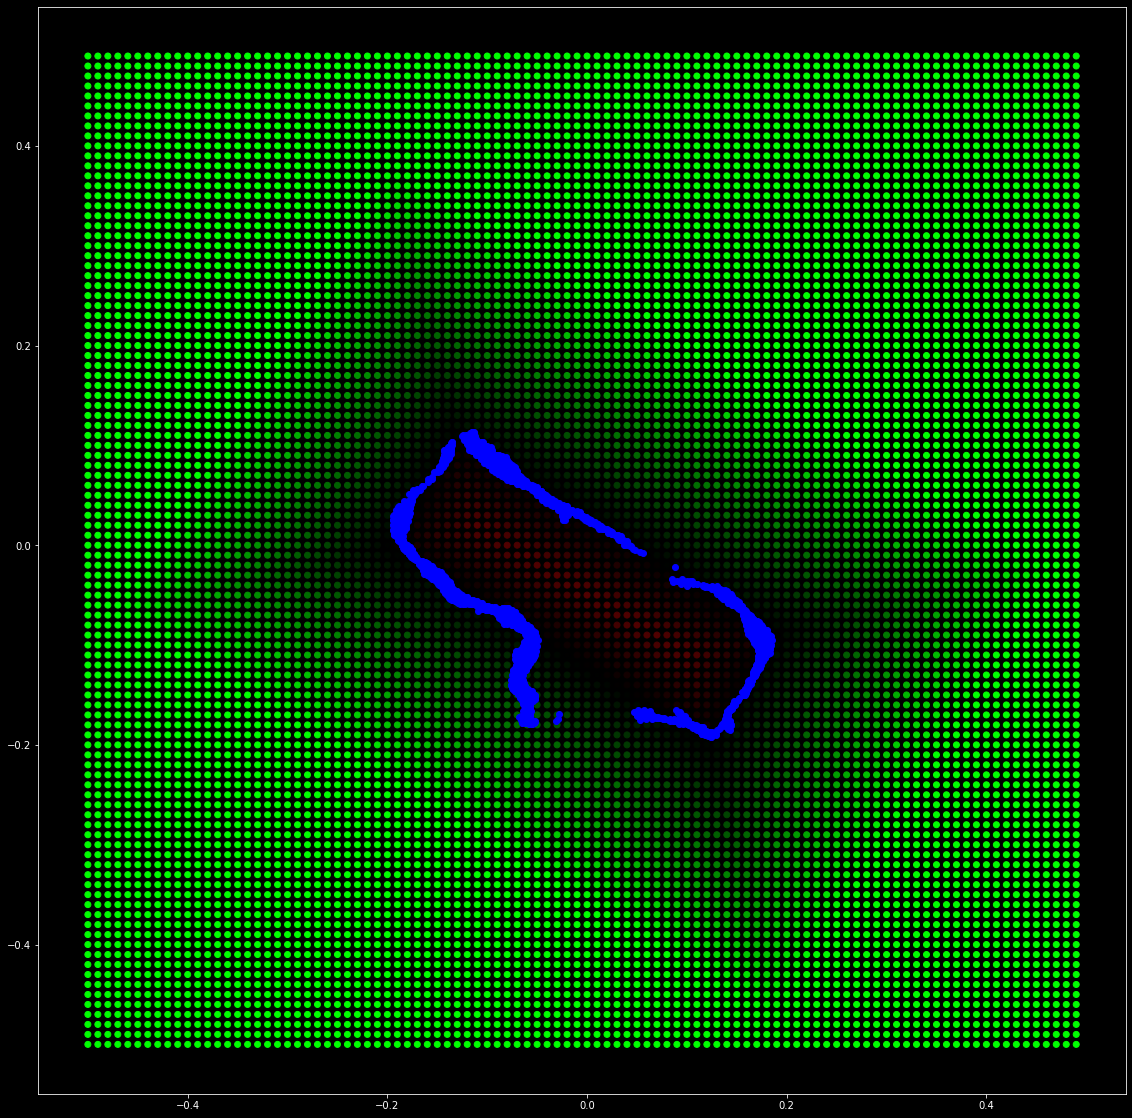

In [131]:
points = np.dstack(np.meshgrid(np.arange(-0.5, 0.5, 0.01), np.arange(-0.5, 0.5, 0.01))).reshape(-1, 2)
val = rect(final_res, points[:, 0], points[:, 1]) * 5
val = np.clip(val, -1, 1)
color = [((0,v,0) if v > 0 else (-v,0,0)) for v in val]
plt.figure(figsize=(20,20))
plt.gca().set_aspect('equal')
plt.scatter(points[:, 0], points[:, 1], c=color)
plt.scatter(coordinates[:, 0], coordinates[:, 1], c="b")